<a href="https://colab.research.google.com/github/Harishkumar01/IntrusionDetectionModel/blob/master/IntrusionDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating a Model for Network Intrusion Detection

Objective is to select best model to predict whether the given data packet is malicious or normal

This done by two steps which is proper preprocessing of data followed by training it to different models and validating the resuts.

In [71]:
#importing requires modules
import pandas as pd
import seaborn as sns
import sklearn
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


In [72]:
#mounting drive for importing dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
#importing dataset
train_data = pd.read_csv("/content/drive/My Drive/ML_network_dataset/Train_data.csv")
test_data = pd.read_csv("/content/drive/My Drive/ML_network_dataset/Test_data.csv")

In [74]:
#displaying train and test data
print(train_data.head())
print(test_data.head())

   duration protocol_type  ... dst_host_srv_rerror_rate    class
0         0           tcp  ...                     0.00   normal
1         0           udp  ...                     0.00   normal
2         0           tcp  ...                     0.00  anomaly
3         0           tcp  ...                     0.01   normal
4         0           tcp  ...                     0.00   normal

[5 rows x 42 columns]
   duration protocol_type  ... dst_host_rerror_rate dst_host_srv_rerror_rate
0         0           tcp  ...                 1.00                     1.00
1         0           tcp  ...                 1.00                     1.00
2         2           tcp  ...                 0.00                     0.00
3         0          icmp  ...                 0.00                     0.00
4         1           tcp  ...                 0.83                     0.71

[5 rows x 41 columns]


## Preprocessing of data

The feature 'num_outbound_cmds' is redundant, so droping it.

In [75]:
print(train_data['num_outbound_cmds'].value_counts())
print(test_data['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [76]:
train_data.drop(['num_outbound_cmds'], axis=1, inplace=True)
test_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [77]:
train_data['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

Procesing the numerical and catagorical data separately.

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
 
columns_num = train_data.select_dtypes(include=['float64','int64']).columns
train_data_num = scaler.fit_transform(train_data.select_dtypes(include=['float64','int64']))
test_data_num = scaler.fit_transform(test_data.select_dtypes(include=['float64','int64']))
train_data_num = pd.DataFrame(train_data_num, columns = columns_num)
test_data_num = pd.DataFrame(test_data_num, columns = columns_num)

print(train_data_num.head())
print(test_data_num.head())

   duration  src_bytes  ...  dst_host_rerror_rate  dst_host_srv_rerror_rate
0 -0.113551  -0.009889  ...             -0.221668                 -0.374281
1 -0.113551  -0.010032  ...             -0.385140                 -0.374281
2 -0.113551  -0.010093  ...             -0.385140                 -0.374281
3 -0.113551  -0.009996  ...             -0.385140                 -0.342768
4 -0.113551  -0.010010  ...             -0.385140                 -0.374281

[5 rows x 37 columns]
   duration  src_bytes  ...  dst_host_rerror_rate  dst_host_srv_rerror_rate
0 -0.155534  -0.021988  ...              1.979791                  1.929116
1 -0.155534  -0.021988  ...              1.979791                  1.929116
2 -0.154113   0.005473  ...             -0.602719                 -0.565483
3 -0.155534  -0.021946  ...             -0.602719                 -0.565483
4 -0.154823  -0.021988  ...              1.540764                  1.205682

[5 rows x 37 columns]


In [79]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_data_cat = train_data.select_dtypes(include=['object']).copy()
test_data_cat = test_data.select_dtypes(include=['object']).copy()
train_data_cat = train_data_cat.apply(encoder.fit_transform)
test_data_cat = test_data_cat.apply(encoder.fit_transform)

train_data_cat_X = train_data_cat.drop(['class'], axis=1)
train_data_cat_Y = train_data_cat[['class']].copy()

In [80]:
train_x = pd.concat([train_data_num,train_data_cat_X],axis=1)
train_y = train_data['class']
train_x.shape
test_data_ = pd.concat([test_data_num,test_data_cat],axis=1)
test_data_.shape

(22544, 40)

Processed data

In [81]:
print(train_x)
print(train_y)
print(test_data_)

       duration  src_bytes  dst_bytes  ...  protocol_type  service  flag
0     -0.113551  -0.009889  -0.039310  ...              1       19     9
1     -0.113551  -0.010032  -0.039310  ...              2       41     9
2     -0.113551  -0.010093  -0.039310  ...              1       46     5
3     -0.113551  -0.009996   0.052473  ...              1       22     9
4     -0.113551  -0.010010  -0.034582  ...              1       22     9
...         ...        ...        ...  ...            ...      ...   ...
25187 -0.113551  -0.010093  -0.039310  ...              1       16     2
25188 -0.113551  -0.009954  -0.039310  ...              1       19     9
25189 -0.113551  -0.010093  -0.039310  ...              1       46     1
25190 -0.113551  -0.010093  -0.039310  ...              1       38     5
25191 -0.113551  -0.010093  -0.039310  ...              1       17     5

[25192 rows x 40 columns]
0         normal
1         normal
2        anomaly
3         normal
4         normal
          ..

Performing **Forward Selection** for feature Selection

In [39]:
#increse the number of features to be selected as needed(now its set to 15 out of 40)
forwardres = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1),
         k_features = 15,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(train_x, train_y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished

[2020-07-13 06:32:30] Features: 1/15 -- score: 0.962289615751032[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:  1.9min finished

[2020-07-13 06:34:27] Features: 2/15 -- score: 0.9875357256271832[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:  2.0min finished

[2020-07-13 06:36:26] Features: 3/15 -- score: 0.9939663385201651[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:  2.0min finished

[2020-07-13 06:38:23] Features: 4/15 -- score: 0.9959114004445856[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n

In [82]:
#selected features and resulting dataset
features = pd.array(forwardres.k_feature_names_)
print(features)
traindata_ = train_x[features]
print(traindata_.head())

<StringArray>
[                'duration',                'src_bytes',
                'dst_bytes',                     'land',
             'su_attempted',       'num_file_creations',
          'srv_rerror_rate',            'same_srv_rate',
   'dst_host_same_srv_rate',     'dst_host_serror_rate',
 'dst_host_srv_serror_rate',     'dst_host_rerror_rate',
            'protocol_type',                  'service',
                     'flag']
Length: 15, dtype: string
   duration  src_bytes  dst_bytes  ...  protocol_type  service  flag
0 -0.113551  -0.009889  -0.039310  ...              1       19     9
1 -0.113551  -0.010032  -0.039310  ...              2       41     9
2 -0.113551  -0.010093  -0.039310  ...              1       46     5
3 -0.113551  -0.009996   0.052473  ...              1       22     9
4 -0.113551  -0.010010  -0.034582  ...              1       22     9

[5 rows x 15 columns]


# Training the models

In [83]:
#splitting train to train and test to feed the model and evaluate
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(traindata,train_y,train_size=0.70, random_state=2)

In [84]:
#importing four selected models
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

#LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

#NaiveBayes Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
#DecisionTree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [85]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score


selected_models = []
#evaluating each models
selected_models.append(('Naive Baye Classifier', BNB_Classifier))
selected_models.append(('Decision Tree Classifier', DTC_Classifier))
selected_models.append(('KNeighborsClassifier', KNN_Classifier))
selected_models.append(('LogisticRegression', LGR_Classifier))

for i, j in models:
    scores = cross_val_score(j, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, j.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, j.predict(X_train))
    classification = metrics.classification_report(Y_train, j.predict(X_train))
    print()
    print('++++++++++++++++++++++++++++ {} Model Evaluation Result +++++++++++++++++++++++++++++++'.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()



++++++++++++++++++++++++++++ Naive Baye Classifier Model Evaluation Result +++++++++++++++++++++++++++++++

Cross Validation Mean Score:
 0.8898706145343371

Model Accuracy:
 0.8898718384938188

Confusion matrix:
 [[6748 1497]
 [ 445 8944]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.94      0.82      0.87      8245
      normal       0.86      0.95      0.90      9389

    accuracy                           0.89     17634
   macro avg       0.90      0.89      0.89     17634
weighted avg       0.89      0.89      0.89     17634



++++++++++++++++++++++++++++ Decision Tree Classifier Model Evaluation Result +++++++++++++++++++++++++++++++

Cross Validation Mean Score:
 0.9961439992900166

Model Accuracy:
 1.0

Confusion matrix:
 [[8245    0]
 [   0 9389]]

Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8245
      normal       1.00      1.00      1.

In [86]:
#Testing the models
accuracyofmodels = []

for i, j in models:
    accuracy = metrics.accuracy_score(Y_test, j.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, j.predict(X_test))
    classification = metrics.classification_report(Y_test, j.predict(X_test))
    print()
    print('++++++++++++++++++++++++++++++++ {} Model Test Result ++++++++++++++++++++++++++++'.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()
    accuracyofmodels.append(accuracy)

print(accuracyofmodels)
best_model = accuracyofmodels.index(max(accuracyofmodels))
print(best_model)   


++++++++++++++++++++++++++++++++ Naive Baye Classifier Model Test Result ++++++++++++++++++++++++++++

Model Accuracy:
 0.8885948663667637

Confusion matrix:
 [[2876  622]
 [ 220 3840]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.93      0.82      0.87      3498
      normal       0.86      0.95      0.90      4060

    accuracy                           0.89      7558
   macro avg       0.89      0.88      0.89      7558
weighted avg       0.89      0.89      0.89      7558



++++++++++++++++++++++++++++++++ Decision Tree Classifier Model Test Result ++++++++++++++++++++++++++++

Model Accuracy:
 0.9951045250066155

Confusion matrix:
 [[3487   11]
 [  26 4034]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.99      1.00      0.99      3498
      normal       1.00      0.99      1.00      4060

    accuracy                           1.00      7558
   macro avg       0.99    

Predicting the state of the packet using the best trained model

Best model for given dataset is [Decision Tree Classifier] and evaluating test dataset based on that model
   duration  src_bytes  dst_bytes  ...  service  flag        0
0 -0.155534  -0.021988  -0.096896  ...       45     1  anomaly
1 -0.155534  -0.021988  -0.096896  ...       45     1  anomaly
2 -0.154113   0.005473  -0.096896  ...       19     9   normal
3 -0.155534  -0.021946  -0.096896  ...       13     9  anomaly
4 -0.154823  -0.021988  -0.096189  ...       55     2  anomaly

[5 rows x 41 columns]


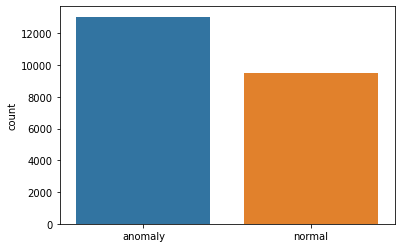

In [90]:
#selecting features in test data
testdata_ = test_data_[features]

if best_model == 0:
  print("Best model for given dataset is [Naive Baye Classifier] and evaluating test dataset based on that model")
  pred_NB = BNB_Classifier.predict(testdata_)
  pred_NB_list = list(pred_NB)
  pres_NB = pd.DataFrame(pred_NB)
  result = pd.concat([test_data_, pred_NB],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_NB_list)
elif best_model == 1:
  print("Best model for given dataset is [Decision Tree Classifier] and evaluating test dataset based on that model")
  pred_dt = DTC_Classifier.predict(testdata_)
  pred_dtc_list = list(pred_dt)
  pred_dt = pd.DataFrame(pred_dt)
  result = pd.concat([test_data_, pred_dt],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_dtc_list)
elif best_model == 2:
  print("Best model for given dataset is [KNeighbors Classifier] and evaluating test dataset based on that model")
  pred_knn = KNN_Classifier.predict(testdata_)
  pred_knn_list = list(pred_knn)
  pred_knn = pd.DataFrame(pred_knn)
  result = pd.concat([test_data_, pred_knn],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_knn_list)
else:
  print("Best model for given dataset is [LogisticRegression] and evaluating test dataset based on that model")
  pred_log = LGR_Classifier.predict(testdata_)
  pred_log_list = list(pred_log)
  pred_log = pd.DataFrame(pred_log)
  result = pd.concat([test_data_, pred_log],axis=1)
  result.shape
  print(result.head())
  sns.countplot(pred_log_list)
  


Hence, the packet of class anomaly are malicious

# Thank You